# Loading libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, LSTM, Bidirectional, concatenate, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.utils import plot_model

from unidecode import unidecode
from os.path import isfile

Using TensorFlow backend.


In [2]:
# Data prepraration: Converting text to sequences
class TF_Data:
    def __init__(self, df, train_test_split, top_words):
        self.top_words = top_words
        self.train_test_split = train_test_split
        self.df = df
        self.review = self.df['review'].as_matrix()
        self.tokenizer = Tokenizer(top_words)
        self.tokenizer.fit_on_texts(self.review)
        self.all_x = np.array(self.tokenizer.texts_to_sequences(self.review))

    def load_data(self, Y):
        df = pd.get_dummies(Y['rating'])
        self.all_y = df.values
        
        split = int(self.train_test_split * len(self.all_x))
        training_x = self.all_x[:split]
        training_y = self.all_y[:split]
        testing_x = self.all_x[split:]        
        testing_y = self.all_y[split:]
        return (training_x, training_y), (testing_x, testing_y)

In [3]:
# removing unnecessary characters and converting strings to lower case
def clean_review(row):
    whitelist = set('abcdefghijklmnopqrstuvwxyz 0123456789.,;\'-:?#$&*!^')
    result = ''.join(filter(whitelist.__contains__, row))
    result = result.lower() 
    return result

## CNN Architecture 

In [4]:
def cnn_model(X_train, X_test, y_train, y_test, classes):
    review = Input(shape=(300,), dtype='float', name='review')
    embedding_vectors = Embedding(output_dim=32, input_dim= 10000, input_length=300)(review)
    conv_1 = Conv1D(filters=32, kernel_size=5, activation='relu')(embedding_vectors)
    max_pool_1 = MaxPooling1D(pool_size=2)(conv_1)
    conv_2 = Conv1D(filters=32, kernel_size=3, activation='relu')(max_pool_1)
    max_pool_2 = MaxPooling1D(pool_size=2)(conv_2)
    flatten = Flatten()(max_pool_2)
    main_output = Dense(classes, activation='sigmoid', name='main_output')(flatten)

    model = Model(inputs=[review], outputs=[main_output])
    optimizer = Adam(lr=1e-2)
    model.compile(optimizer= optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    print('Fitting the model now.....')
    history = model.fit([X_train], y_train, validation_split=0.25, epochs=5, batch_size=1024)

    print('Evaluating the model now.....')
    scores = model.evaluate([X_train], y_train, verbose=0)
    print ('Train - Accuracy of CNN Model is: ', scores[1]*100)
    scores = model.evaluate([X_test], y_test, verbose=0)
    print ('Test - Accuracy of CNN Model is: ', scores[1]*100)
    
    plt.figure(figsize = [10, 7])
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'], 'bo-', color='maroon')
    plt.plot(history.history['val_acc'], 'bo-', color='orange')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.figure(figsize = [10, 7])
    # Plot training & validation loss values
    plt.plot(history.history['loss'], 'bo-', color='purple')
    plt.plot(history.history['val_loss'], 'bo-', color='orange')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

## LSTM Architecture

In [5]:
def lstm_model(X_train, X_test, y_train, y_test, classes):
    review = Input(shape=(300,), dtype='float', name='review')
    embedding_vectors = Embedding(output_dim=32, input_dim= 10000, input_length=300)(review)
    lstm_out = LSTM(100)(embedding_vectors)
    dense = Dense(32, activation='relu')(lstm_out)
    main_output = Dense(classes, activation='sigmoid', name='main_output')(dense)

    model = Model(inputs=[review], outputs=[main_output])
    optimizer = Adam(lr=1e-2)
    model.compile(optimizer= optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    print('Fitting the model now.....')
    history = model.fit([X_train], y_train, validation_split=0.25, epochs=8, batch_size=1024)
    
    print('Evaluating the model now.....')
    scores = model.evaluate([X_train], y_train, verbose=0)
    print ('Train - Accuracy of LSTM Model is: ', scores[1]*100)
    scores = model.evaluate([X_test], y_test, verbose=0)
    print ('Test - Accuracy of LSTM Model is: ', scores[1]*100)
    
    plt.figure(figsize = [10, 7])
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'], 'bo-', color='maroon')
    plt.plot(history.history['val_acc'], 'bo-', color='orange')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.figure(figsize = [10, 7])
    # Plot training & validation loss values
    plt.plot(history.history['loss'], 'bo-', color='purple')
    plt.plot(history.history['val_loss'], 'bo-', color='orange')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

Amazon_baby
Train data size:  (127727, 4)
Test data size:  (54657, 4)
Number of target labels are:  5
Done pre-peocessing...
Padding...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review (InputLayer)          (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 32)           5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 148, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 146, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 73, 32)            0         
______

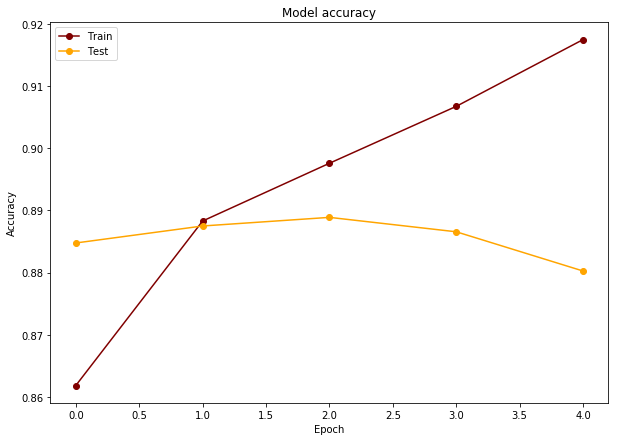

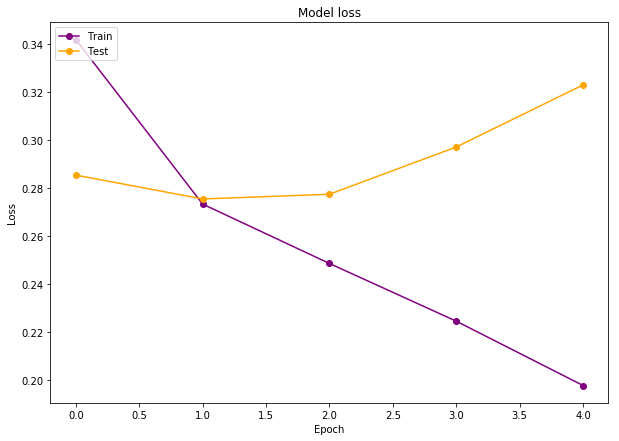

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review (InputLayer)          (None, 300)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
main_output (Dense)          (None, 5)                 165       
Total params: 376,597
Trainable params: 376,597
Non-trainable params: 0
_________________________________________________________________
None
Fitting the model now.....
Train on 95751 samples, validate on 31917 samples
Epoch 1/8
95751/95751 [==============================]

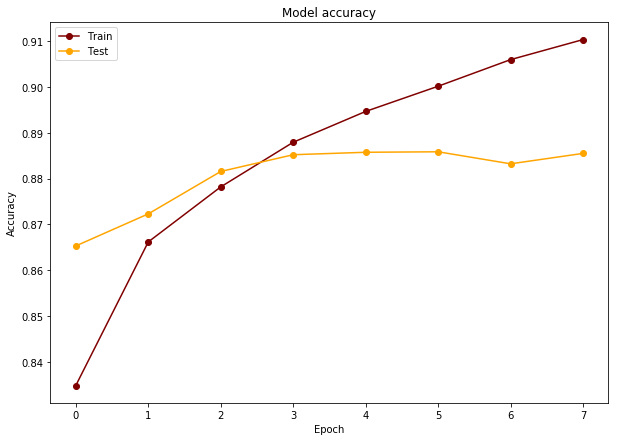

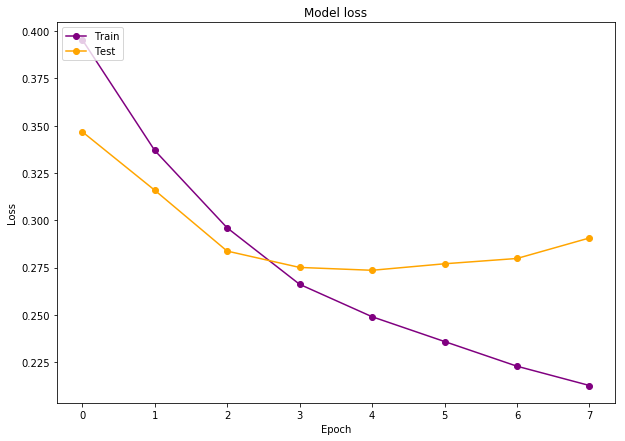

DrugsCom
Train data size:  (160398, 9)
Test data size:  (53471, 9)
Number of target labels are:  5
Done pre-peocessing...
Padding...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review (InputLayer)          (None, 300)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 296, 32)           5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 148, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 146, 32)           3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 73, 32)            0         
_________

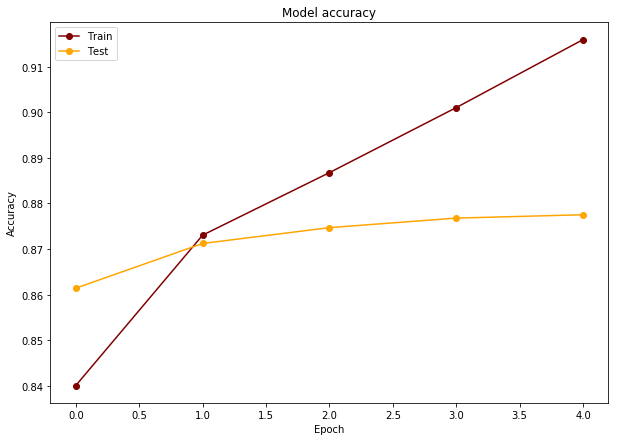

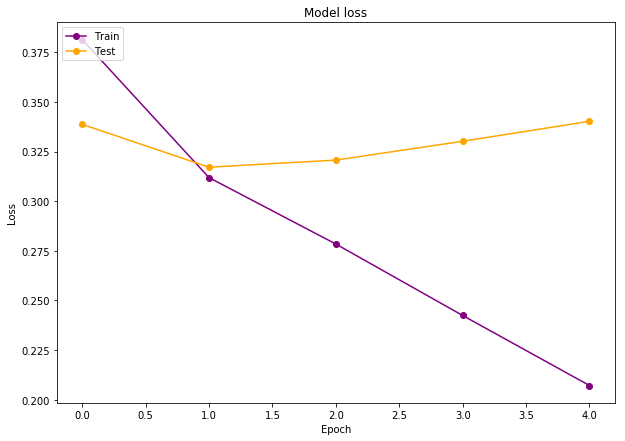

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review (InputLayer)          (None, 300)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                3232      
_________________________________________________________________
main_output (Dense)          (None, 5)                 165       
Total params: 376,597
Trainable params: 376,597
Non-trainable params: 0
_________________________________________________________________
None
Fitting the model now.....
Train on 112281 samples, validate on 37427 samples
Epoch 1/8
112281/112281 [============================

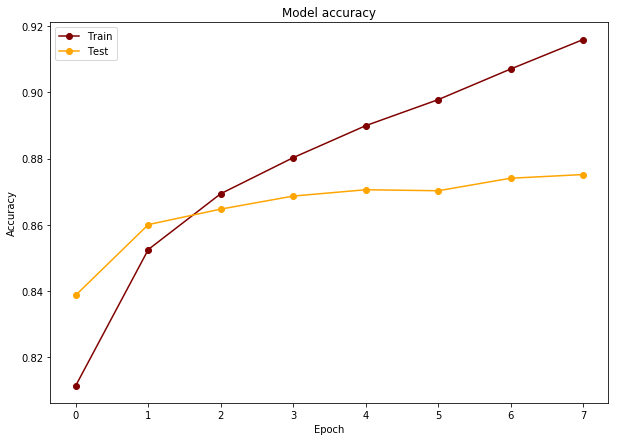

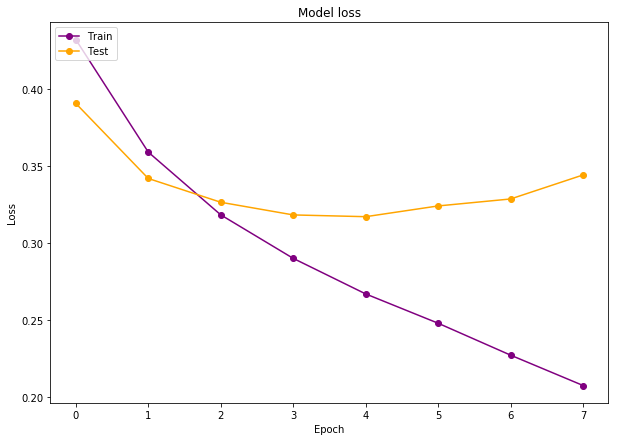

IMDB
Train data size:  (75000, 3)
Test data size:  (25000, 3)
Number of target labels are:  3
Done pre-peocessing...
Padding...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review (InputLayer)          (None, 300)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 296, 32)           5152      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 148, 32)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 146, 32)           3104      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 73, 32)            0         
______________

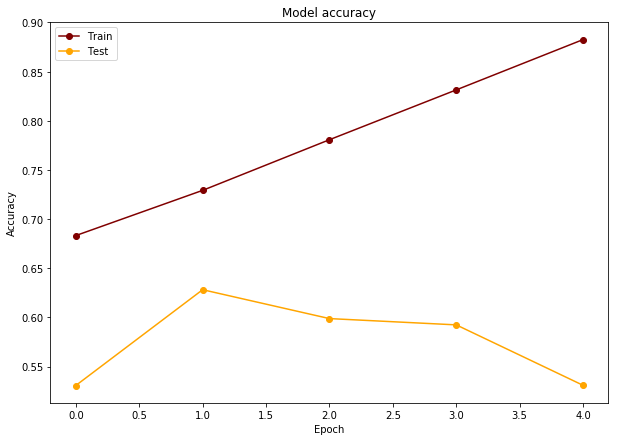

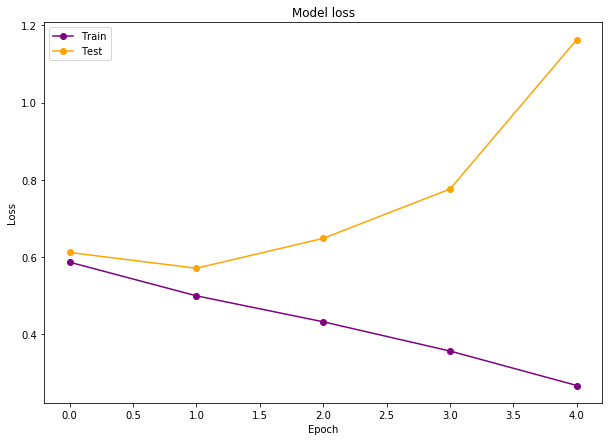

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
review (InputLayer)          (None, 300)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                3232      
_________________________________________________________________
main_output (Dense)          (None, 3)                 99        
Total params: 376,531
Trainable params: 376,531
Non-trainable params: 0
_________________________________________________________________
None
Fitting the model now.....
Train on 52500 samples, validate on 17500 samples
Epoch 1/8
52500/52500 [==============================]

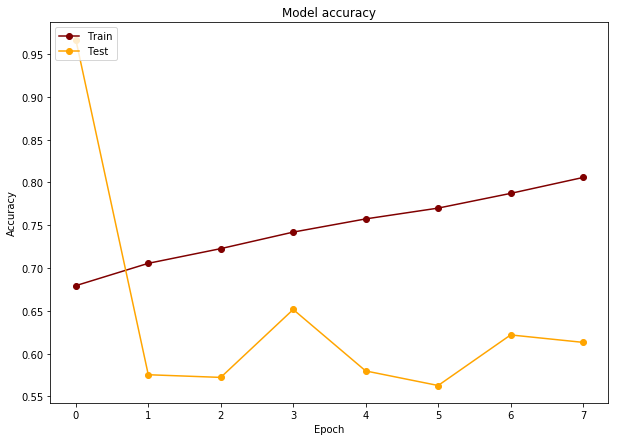

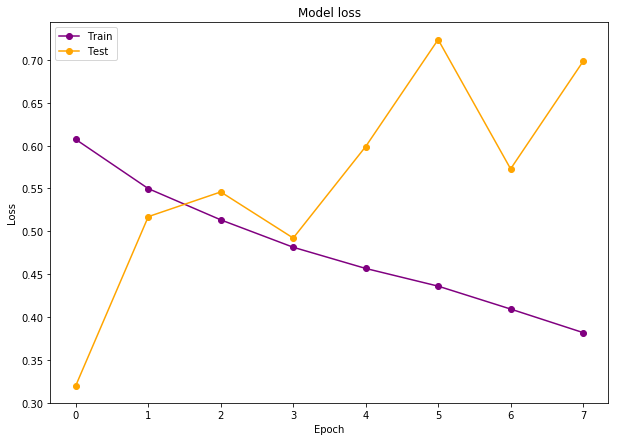

In [6]:
folders = ['Amazon_baby', 'DrugsCom', 'IMDB']
for folder in folders:
    print (folder)
    folder_path = os.path.join(os.getcwd(), folder)
    train_df = pd.read_csv(os.path.join(folder_path, 'train.csv'))
    test_df = pd.read_csv(os.path.join(folder_path, 'test.csv'))
    train_df = train_df.dropna()
    test_df = test_df.dropna()
    print ('Train data size: ', train_df.shape)
    print ('Test data size: ', test_df.shape)
    
    train_df['review'] = train_df['review'].apply(lambda x: clean_review(x))
    test_df['review'] = test_df['review'].apply(lambda x: clean_review(x))
    data = train_df.append(test_df)
    classes = len(np.unique(data['rating'].values))
    print ('Number of target labels are: ', classes)
    
    print ('Done pre-peocessing...')
    top_words = 10000
    data_obj = TF_Data(data, train_test_split=0.7, top_words=top_words)
    (X_train, y_train), (X_test, y_test) = data_obj.load_data(data)

    print ('Padding...')
    max_review_length = 300
    X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
    X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
    
    cnn_model(X_train, X_test, y_train, y_test, classes)
    lstm_model(X_train, X_test, y_train, y_test, classes)